# Compare I2EM vs NMM3D LUT (40° incidence)

This notebook compares co-pol (VV, HH) and cross-pol (VH) backscatter from the I2EM bindings in this repo
against NMM3D simulations provided via the lookup table `NMM3D_LUT_NRCS_40degree.dat`.

- Frequency is configurable (default 5.405 GHz).
- Monostatic geometry at 40° incidence.
- Surface ACF selectable via `sp` (1=exponential, 2=Gaussian).
- Cross-pol computed via IEMX model.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyi2em

DATA_PATH = '../NMM3D_LUT_NRCS_40degree.dat'

# Physical constants
c0 = 299792458.0  # m/s

def wavelength_cm(fGHz: float) -> float:
    """Return wavelength in cm for frequency in GHz.
    Consistent with c0/(fGHz*1e7) used in the reference code.
    """
    return c0 / (fGHz * 1e7)

def _bilinear(grid, x_vals, y_vals, x0, y0):
    """Simple bilinear interpolation on a rectilinear grid.
    grid shape: (len(y_vals), len(x_vals)) corresponding to (y, x).
    """
    # Clamp within range
    x0 = np.clip(x0, x_vals[0], x_vals[-1])
    y0 = np.clip(y0, y_vals[0], y_vals[-1])
    xi = np.searchsorted(x_vals, x0)
    yi = np.searchsorted(y_vals, y0)
    if xi == 0:
        x1i, x2i = 0, 1
    elif xi >= len(x_vals):
        x1i, x2i = len(x_vals)-2, len(x_vals)-1
    else:
        x1i, x2i = xi-1, xi
    if yi == 0:
        y1i, y2i = 0, 1
    elif yi >= len(y_vals):
        y1i, y2i = len(y_vals)-2, len(y_vals)-1
    else:
        y1i, y2i = yi-1, yi
    x1, x2 = x_vals[x1i], x_vals[x2i]
    y1, y2 = y_vals[y1i], y_vals[y2i]
    Q11 = grid[y1i, x1i]
    Q21 = grid[y1i, x2i]
    Q12 = grid[y2i, x1i]
    Q22 = grid[y2i, x2i]
    # Handle potential NaNs by simple nearest fallback
    if not np.isfinite([Q11, Q21, Q12, Q22]).all():
        # nearest
        ni = (np.abs(x_vals - x0)).argmin()
        nj = (np.abs(y_vals - y0)).argmin()
        return float(grid[nj, ni])
    # Bilinear weights
    if x2 == x1 or y2 == y1:
        return float(Q11)
    tx = (x0 - x1) / (x2 - x1)
    ty = (y0 - y1) / (y2 - y1)
    return float((Q11 * (1-tx) * (1-ty) + Q21 * tx * (1-ty) + Q12 * (1-tx) * ty + Q22 * tx * ty))

def NMM3D_LUT_NRCS_40degree_interp(rms0, eps0, ratio0, filepath=DATA_PATH):
    LUT = np.loadtxt(filepath)
    LUT = LUT[:, 1:]  # drop incidence angle column (always 40)

    ratio_vals = np.array([4, 7, 10, 15])
    if ratio0 < ratio_vals[0] or ratio0 > ratio_vals[-1]:
        raise ValueError('ratio0 is out of range')

    def _rblock_interp(LUT, ratio, eps0, rms0):
        block = LUT[LUT[:, 0] == ratio]
        if block.size == 0:
            raise ValueError(f'No data block for ratio={ratio}')
        eps_unique = np.unique(block[:, 1])
        rms_unique = np.unique(block[:, 3])
        # bound to range
        eps0_ = np.clip(eps0, eps_unique[0], eps_unique[-1])
        rms0_ = np.clip(rms0, rms_unique[0], rms_unique[-1])
        grid_shape = (len(rms_unique), len(eps_unique))
        vv_grid = np.full(grid_shape, np.nan)
        hh_grid = np.full(grid_shape, np.nan)
        x_grid = np.full(grid_shape, np.nan)
        for row in block:
            j = np.where(eps_unique == row[1])[0][0]
            i = np.where(rms_unique == row[3])[0][0]
            vv_grid[i, j] = row[4]
            hh_grid[i, j] = row[5]
            x_grid[i, j] = row[6]
        vv = _bilinear(vv_grid, eps_unique, rms_unique, eps0_, rms0_)
        hh = _bilinear(hh_grid, eps_unique, rms_unique, eps0_, rms0_)
        x = _bilinear(x_grid, eps_unique, rms_unique, eps0_, rms0_)
        return vv, hh, x

    if ratio0 in ratio_vals:
        return _rblock_interp(LUT, ratio0, eps0, rms0)
    # linear interpolate between nearest ratio blocks
    rs = ratio_vals[ratio_vals < ratio0].max()
    rb = ratio_vals[ratio_vals > ratio0].min()
    vvs, hhs, xs = _rblock_interp(LUT, rs, eps0, rms0)
    vvb, hhb, xb = _rblock_interp(LUT, rb, eps0, rms0)
    def _r_interp(rs, rb, vs, vb, r0):
        if np.isfinite(vs) and np.isfinite(vb):
            return np.interp(r0, [rs, rb], [vs, vb])
        else:
            return -np.inf
    vv = _r_interp(rs, rb, vvs, vvb, ratio0)
    hh = _r_interp(rs, rb, hhs, hhb, ratio0)
    x = _r_interp(rs, rb, xs, xb, ratio0)
    return vv, hh, x


In [2]:
# Parameters
fGHz = 5.405
theta_deg = 40.0
ratio0 = 7            # l/sigma
eps0 = 10.0           # real permittivity (imag=0)
# Quick switch: compare these correlation functions side-by-side
# 1 = exponential, 2 = Gaussian (use [1, 2] to compare both)
compare_sps = [1, 2]

wave_cm = wavelength_cm(fGHz)
k = 2*np.pi / wave_cm
print('wavelength [cm]:', wave_cm)
print('k [1/cm]:', k)

# Sweep RMS (cm) and compare
rms_values_cm = np.linspace(0.2, 1.1, 25)
kk_sig = k * rms_values_cm

# LUT once (independent of sp)
vv_lut, hh_lut, x_lut = [], [], []
for rms_cm in rms_values_cm:
    rms_norm = rms_cm / wave_cm
    vv_v, hh_v, x_v = NMM3D_LUT_NRCS_40degree_interp(rms_norm, eps0, ratio0, filepath=DATA_PATH)
    vv_lut.append(vv_v); hh_lut.append(hh_v); x_lut.append(x_v)
vv_lut = np.array(vv_lut); hh_lut = np.array(hh_lut); x_lut = np.array(x_lut)

# Compute I2EM (VV, HH, VH) for each sp in compare_sps using the combined API
results = {}  # sp -> dict of arrays
for sp in compare_sps:
    vv_i2em, hh_i2em, vh_i2em = [], [], []
    for rms_cm in rms_values_cm:
        sig_m = rms_cm / 100.0
        l_m = (rms_cm * ratio0) / 100.0
        vvhhvh = pyi2em.I2EM_Backscatter_model(fGHz, sig_m, l_m, theta_deg, eps0, 0.0, sp)
        vv_i2em.append(vvhhvh[0]); hh_i2em.append(vvhhvh[1]); vh_i2em.append(vvhhvh[2])
    results[sp] = {
        'VV': np.array(vv_i2em),
        'HH': np.array(hh_i2em),
        'VH': np.array(vh_i2em),
    }

# Choose the first sp in the list as the 'active' set for downstream metrics cell
active_sp = compare_sps[0]
vv_i2em = results[active_sp]['VV']
hh_i2em = results[active_sp]['HH']
vh_i2em = results[active_sp]['VH']

# Inline bias (I2EM - LUT) for each pol and each sp
def finite_bias(a, b):
    m = np.isfinite(a) & np.isfinite(b)
    return float(np.mean(a[m] - b[m])) if np.any(m) else np.nan
for sp in compare_sps:
    b_vv = finite_bias(results[sp]['VV'], vv_lut)
    b_hh = finite_bias(results[sp]['HH'], hh_lut)
    b_vh = finite_bias(results[sp]['VH'], x_lut)
    label = 'exp' if sp == 1 else ('gauss' if sp == 2 else f'sp={sp}')
    print(f"Bias dB (I2EM - LUT) [{label}]: VV={b_vv:.3f}, HH={b_hh:.3f}, VH={b_vh:.3f}")


wavelength [cm]: 5.546576466234968
k [1/cm]: 1.1328042343648839
Bias dB (I2EM - LUT) [exp]: VV=1.492, HH=0.161, VH=-3.396
Bias dB (I2EM - LUT) [gauss]: VV=-2.933, HH=-5.080, VH=-16.137


In [3]:
# Cross-pol tuning knobs (affect I2EM cross-pol only)
xpol_auto_eps = 1e-8   # series auto-selection threshold (smaller => more terms)
xpol_maxeval  = 20000  # integrator max evaluations
xpol_reltol   = 5e-7   # integrator relative tolerance
xpol_abstol   = 0.0    # integrator absolute tolerance

pyi2em.set_xpol_auto_eps(xpol_auto_eps)
pyi2em.set_xpol_integrator(maxeval=xpol_maxeval, reltol=xpol_reltol, abstol=xpol_abstol)


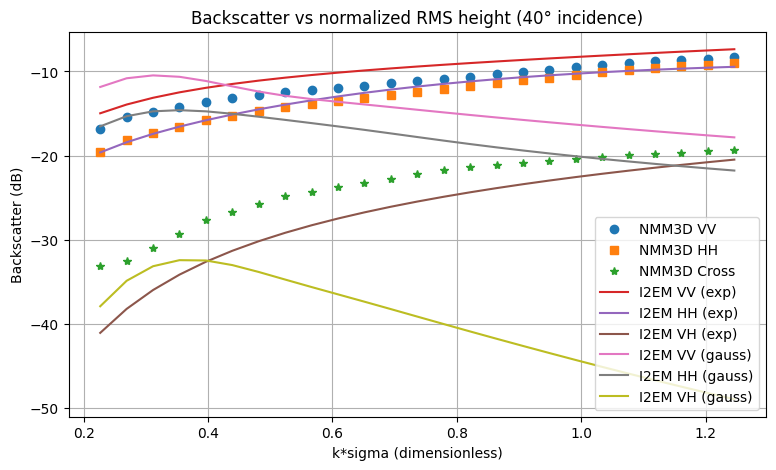

In [4]:
# Plot comparison vs ks (k*sigma)
plt.figure(figsize=(9, 5))
# LUT markers
plt.plot(kk_sig, vv_lut, 'o', label='NMM3D VV')
plt.plot(kk_sig, hh_lut, 's', label='NMM3D HH')
plt.plot(kk_sig, x_lut,  '*', label='NMM3D Cross')

# Overlay I2EM for each sp in compare_sps
for sp in compare_sps:
    lbl = 'exp' if sp == 1 else ('gauss' if sp == 2 else f'sp={sp}')
    plt.plot(kk_sig, results[sp]['VV'], '-', label=f'I2EM VV ({lbl})')
    plt.plot(kk_sig, results[sp]['HH'], '-', label=f'I2EM HH ({lbl})')
    plt.plot(kk_sig, results[sp]['VH'], '-', label=f'I2EM VH ({lbl})')

plt.xlabel('k*sigma (dimensionless)')
plt.ylabel('Backscatter (dB)')
plt.title('Backscatter vs normalized RMS height (40° incidence)')
plt.grid(True); plt.legend(); plt.show()


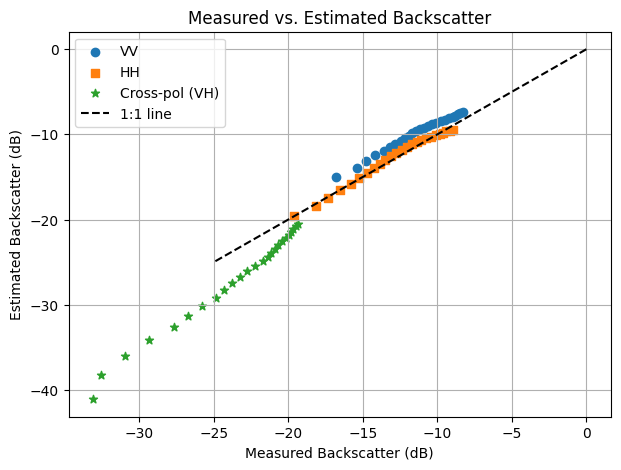

VV: r=0.995, R2=0.554, MSE=2.322(dB^2), RMSE=1.524(dB), Bias=1.492(dB)
HH: r=0.994, R2=0.984, MSE=0.135(dB^2), RMSE=0.367(dB), Bias=0.161(dB)
Cross-pol (VH): r=0.996, R2=0.172, MSE=14.032(dB^2), RMSE=3.746(dB), Bias=-3.396(dB)


In [5]:
# Regression metrics and measured vs estimated scatter
import numpy as np
import matplotlib.pyplot as plt

def regression_metrics(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    # keep only finite pairs
    m = np.isfinite(y_true) & np.isfinite(y_pred)
    y_t = y_true[m]
    y_p = y_pred[m]
    if y_t.size == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan
    # Pearson r
    if y_t.std() == 0 or y_p.std() == 0:
        r = np.nan
    else:
        r = np.corrcoef(y_t, y_p)[0, 1]
    # R^2 (coefficient of determination)
    ss_res = np.sum((y_t - y_p)**2)
    ss_tot = np.sum((y_t - y_t.mean())**2)
    r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else np.nan
    mse = ss_res / y_t.size
    rmse = np.sqrt(mse)
    bias = float(np.mean(y_p - y_t))
    return r, r2, mse, rmse, bias

# Align variable names with the narrative
vv_values = vv_lut
hh_values = hh_lut
xpol_values = x_lut
VV = vv_i2em
HH = hh_i2em
VH = vh_i2em

plt.figure(figsize=(7, 5))
plt.scatter(vv_values, VV, label='VV', marker='o')
plt.scatter(hh_values, HH, label='HH', marker='s')
# Cross-pol: LUT vs I2EM (VH)
m = np.isfinite(xpol_values) & np.isfinite(VH)
plt.scatter(xpol_values[m], VH[m], label='Cross-pol (VH)', marker='*')

# 1:1 line from 0 to -25 dB
plt.plot([0, -25], [0, -25], 'k--', label='1:1 line')

plt.xlabel('Measured Backscatter (dB)')
plt.ylabel('Estimated Backscatter (dB)')
plt.title('Measured vs. Estimated Backscatter')
plt.legend()
plt.grid(True)
plt.show()

# Metrics
r_vv, r2_vv, mse_vv, rmse_vv, bias_vv = regression_metrics(vv_values, VV)
print(f'VV: r={r_vv:.3f}, R2={r2_vv:.3f}, MSE={mse_vv:.3f}(dB^2), RMSE={rmse_vv:.3f}(dB), Bias={bias_vv:.3f}(dB)')

r_hh, r2_hh, mse_hh, rmse_hh, bias_hh = regression_metrics(hh_values, HH)
print(f'HH: r={r_hh:.3f}, R2={r2_hh:.3f}, MSE={mse_hh:.3f}(dB^2), RMSE={rmse_hh:.3f}(dB), Bias={bias_hh:.3f}(dB)')

# Drop non-finite cross-pol values (e.g., -Inf in LUT at very small rms)
m = np.isfinite(xpol_values) & np.isfinite(VH)
r_x, r2_x, mse_x, rmse_x, bias_x = regression_metrics(xpol_values[m], VH[m])
print(f'Cross-pol (VH): r={r_x:.3f}, R2={r2_x:.3f}, MSE={mse_x:.3f}(dB^2), RMSE={rmse_x:.3f}(dB), Bias={bias_x:.3f}(dB)')


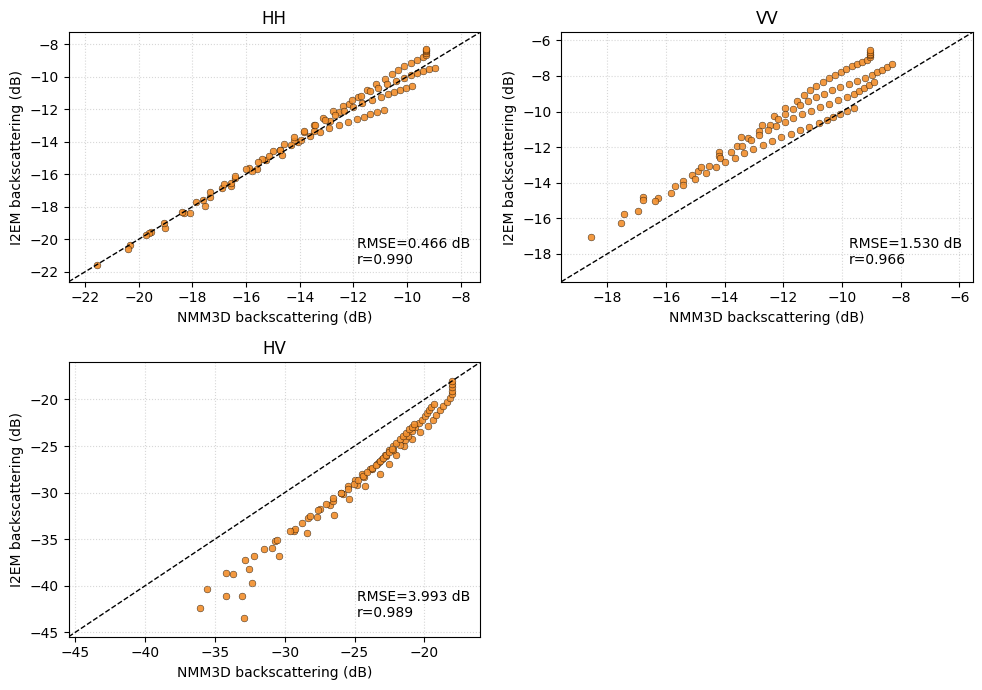

In [6]:
# Separated scatter plots over all NMM3D ratios (exp only): HH, VV, HV
import numpy as np, matplotlib.pyplot as plt

sp_sel = 1  # 1=exponential
ratio_vals = [4, 7, 10, 15]

# Accumulate all pairs across ratios and RMS values
vv_meas, vv_est = [], []
hh_meas, hh_est = [], []
hv_meas, hv_est = [], []

for ratio0 in ratio_vals:
    for rms_cm in rms_values_cm:
        # LUT
        rms_norm = rms_cm / wave_cm
        vv_v, hh_v, x_v = NMM3D_LUT_NRCS_40degree_interp(rms_norm, eps0, ratio0, filepath=DATA_PATH)
        # I2EM
        sig_m = rms_cm / 100.0
        l_m = (rms_cm * ratio0) / 100.0
        vvhhvh = pyi2em.I2EM_Backscatter_model(fGHz, sig_m, l_m, theta_deg, eps0, 0.0, sp_sel)
        # Collect
        vv_meas.append(vv_v); vv_est.append(vvhhvh[0])
        hh_meas.append(hh_v); hh_est.append(vvhhvh[1])
        hv_meas.append(x_v);  hv_est.append(vvhhvh[2])

def _finite_pairs(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    return a[m], b[m]

def _lims(x, y, pad=1.0):
    lo = float(min(np.min(x), np.min(y))) - pad
    hi = float(max(np.max(x), np.max(y))) + pad
    return lo, hi

hh_x, hh_y = _finite_pairs(hh_meas, hh_est)
vv_x, vv_y = _finite_pairs(vv_meas, vv_est)
hv_x, hv_y = _finite_pairs(hv_meas, hv_est)

r_hh, r2_hh, mse_hh, rmse_hh, bias_hh = regression_metrics(hh_x, hh_y)
r_vv, r2_vv, mse_vv, rmse_vv, bias_vv = regression_metrics(vv_x, vv_y)
r_hv, r2_hv, mse_hv, rmse_hv, bias_hv = regression_metrics(hv_x, hv_y)

fig = plt.figure(figsize=(10, 7))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.1])
ax_hh = fig.add_subplot(gs[0, 0])
ax_vv = fig.add_subplot(gs[0, 1])
ax_hv = fig.add_subplot(gs[1, 0])

def scatter_ax(ax, x, y, title, rmse, r):
    lo, hi = _lims(x, y, pad=1.0)
    ax.scatter(x, y, s=24, c='#f28e2b', edgecolors='k', linewidths=0.3, alpha=0.9)
    ax.plot([lo, hi], [lo, hi], 'k--', linewidth=1.0)
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.set_title(title)
    ax.set_xlabel('NMM3D backscattering (dB)')
    ax.set_ylabel('I2EM backscattering (dB)')
    ax.grid(True, linestyle=':', alpha=0.5)
    ax.text(0.7, 0.06, f'RMSE={rmse:.3f} dB\nr={r:.3f}', transform=ax.transAxes,
            ha='left', va='bottom', fontsize=10)

scatter_ax(ax_hh, hh_x, hh_y, 'HH', rmse_hh, r_hh)
scatter_ax(ax_vv, vv_x, vv_y, 'VV', rmse_vv, r_vv)
# HV spanning bottom
lo, hi = _lims(hv_x, hv_y, pad=2.0)
ax_hv.scatter(hv_x, hv_y, s=24, c='#f28e2b', edgecolors='k', linewidths=0.3, alpha=0.9)
ax_hv.plot([lo, hi], [lo, hi], 'k--', linewidth=1.0)
ax_hv.set_xlim(lo, hi); ax_hv.set_ylim(lo, hi)
ax_hv.set_title('HV')
ax_hv.set_xlabel('NMM3D backscattering (dB)')
ax_hv.set_ylabel('I2EM backscattering (dB)')
ax_hv.grid(True, linestyle=':', alpha=0.5)
ax_hv.text(0.7, 0.06, f'RMSE={rmse_hv:.3f} dB\nr={r_hv:.3f}', transform=ax_hv.transAxes,
          ha='left', va='bottom', fontsize=10)

plt.tight_layout(); plt.show()